In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import pandas as pd
from glob import glob
import os
from matplotlib.patches import Rectangle
#图片种类
det_class_path = './input/stage_1_detailed_class_info.csv'
#训练集中bbox的位置信息
bbox_path = './input/stage_1_train_labels.csv'
#训练集dcm格式图片
dicom_dir = './input/stage_1_train_images/'

28989 class infos loaded
7d674c82-5501-4730-92c5-d241fd6911e7    4
ee820aa5-4804-4984-97b3-f0a71d69702f    4
76f71a93-8105-4c79-a010-0cfa86f0061a    4
32408669-c137-4e8d-bd62-fe8345b40e73    4
8dc8e54b-5b05-4dac-80b9-fa48878621e2    4
349f10b4-dc3e-4f3f-b2e4-a5b81448ce87    4
1bf08f3b-a273-4f51-bafa-b55ada2c23b5    4
0ab261f9-4eb5-42ab-a9a5-e918904d6356    4
0d5bc737-03de-4bb8-98a1-45b7180c3e0f    4
3239951b-6211-4290-b237-3d9ad17176db    4
31764d54-ea3b-434f-bae2-8c579ed13799    4
351fe1bb-2966-43a1-9837-fc9664c05266    3
863a923a-3906-42d3-92db-76c900091fce    3
338e80a6-7b26-4133-b051-a40e063d39a3    3
c252072c-c7c9-40a8-819b-5c7952d10bf2    3
316eed14-0f52-44f9-8be0-12e045324a4a    3
b2314db2-44f7-4fea-9a4a-a0d22f518ac6    3
3fdcd01b-1029-40c9-be8a-a72876d0323b    3
8a233483-8ab2-4cc5-b32b-20fe40cc5d77    3
aea56cac-4a31-44b4-b007-1385775d939d    3
e17e53a5-916f-40c8-9c9c-dcc01031aa46    3
31ba8a38-bc46-4208-9225-f4a6290d7966    3
3218b157-1f46-4da3-863f-9b97ae22308f    3
9131bb85-

,patientId,class
13538,87f877e7-ad10-4b37-aac3-ff05c4dc7a6f,Normal
22422,cab975f6-28c4-418d-b6da-6cd6a4f8d902,Normal
256,06550cfd-e9d5-415e-bae9-3146329ed9e6,Lung Opacity
20714,bcccd58e-6cf0-4bd8-82c1-e51e18cd041b,Lung Opacity


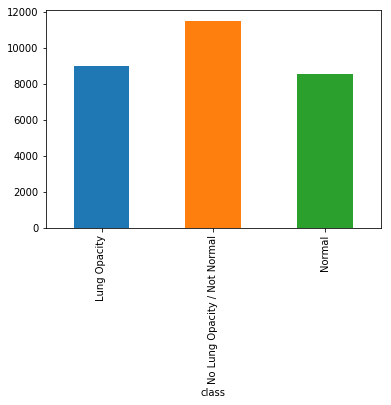

In [6]:
#打开csv文件
det_class_df = pd.read_csv(det_class_path)
#输出csv表格的行数
print(det_class_df.shape[0], 'class infos loaded')
#获取名为'patientid'的列，value_counts()统计数据重复次数，key为数据，value为重复次数，故shape【0】返回没有重复的数据个数
print(det_class_df['patientId'].value_counts().shape[0], 'patient cases')
#groupby以class的值进行分组，size()根据数据数量进行排列
det_class_df.groupby('class').size().plot.bar()
#选取3条数据
det_class_df.sample(4)


In [7]:
bbox_df = pd.read_csv(bbox_path)
print(bbox_df.shape[0], 'boxes loaded')
print(bbox_df['patientId'].value_counts().shape[0], 'patient cases')
bbox_df.sample(3)

28989 boxes loaded
25684 patient cases


,patientId,x,y,width,height,Target
27911,f794dead-5aa3-438e-a185-a74fab95616d,NaN,NaN,NaN,NaN,0
164,052e09c0-6747-4f72-8e71-96fcc489043a,NaN,NaN,NaN,NaN,0
22627,cc5a6673-3143-4f18-a404-da9952898059,NaN,NaN,NaN,NaN,0


In [8]:
#concat合并两个csv表，def_class_df使用drop删掉了patienid的列数据，axis=1表示按列进行合并，根据id进行合并
comb_bbox_df = pd.concat([bbox_df, det_class_df.drop('patientId',1)], 1)
print(comb_bbox_df.shape[0], 'combined cases')
comb_bbox_df.sample(3)

28989 combined cases


,patientId,x,y,width,height,Target,class
17781,a94b358c-1e82-484b-a36b-462bd297f9d6,515.0,419.0,242.0,375.0,1,Lung Opacity
12498,7f5c19bf-ea76-4979-8fa8-f750f6550993,NaN,NaN,NaN,NaN,0,Normal
20097,b9069b7c-4da9-491c-b105-8c5edd6a7d1e,NaN,NaN,NaN,NaN,0,Normal


In [14]:
box_df = comb_bbox_df.groupby('patientId').\
    size().\
    reset_index(name='boxes')
comb_box_df = pd.merge(comb_bbox_df, box_df, on='patientId')
print(comb_box_df)
#调用siz才能查看分组后每组内的数量
box_df.\
    groupby('boxes').\
    size().\
    reset_index(name='patients')

                                  patientId      x      y  width  height  \
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN   
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN   
2      00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN   
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN   
4      00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0   
5      00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0   
6      00569f44-917d-4c86-a842-81832af98c30    NaN    NaN    NaN     NaN   
7      006cec2e-6ce2-4549-bffa-eadfcd1e9970    NaN    NaN    NaN     NaN   
8      00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0   
9      00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0   
10     008c19e8-a820-403a-930a-bc74a4053664    NaN    NaN    NaN     NaN   
11     009482dc-3db5-48d4-8580-5c89c4f01334    NaN    NaN    NaN     NaN   
12     009eb

,boxes,patients
0,1,22506
1,2,3062
2,3,105
3,4,11


In [15]:
comb_bbox_df.groupby(['class', 'Target']).size().reset_index(name='Patient Count')

,class,Target,Patient Count
0,Lung Opacity,1,8964
1,No Lung Opacity / Not Normal,0,11500
2,Normal,0,8525


In [16]:
image_df = pd.DataFrame({'path': glob(os.path.join(dicom_dir, '*.dcm'))})
image_df['patientId'] = image_df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
print(image_df.shape[0], 'images found')
img_pat_ids = set(image_df['patientId'].values.tolist())
box_pat_ids = set(comb_box_df['patientId'].values.tolist())
# check to make sure there is no funny business
assert img_pat_ids.union(box_pat_ids)==img_pat_ids, "Patient IDs should be the same"

25684 images found


,BodyPartExamined,PatientSex,ViewPosition
count,25684,25684,25684
unique,1,2,2
top,CHEST,M,PA
freq,25684,14593,13979


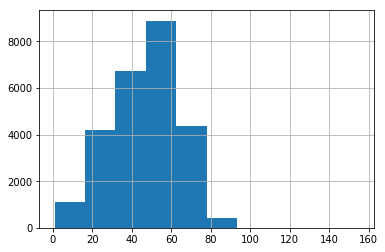

In [20]:
DCM_TAG_LIST = ['PatientAge', 'BodyPartExamined', 'ViewPosition', 'PatientSex']
def get_tags(in_path):
    c_dicom = pydicom.read_file(in_path, stop_before_pixels=True)
    tag_dict = {c_tag: getattr(c_dicom, c_tag, '') 
         for c_tag in DCM_TAG_LIST}
    tag_dict['path'] = in_path
    return pd.Series(tag_dict)
image_meta_df = image_df.apply(lambda x: get_tags(x['path']), 1)
# show the summary
image_meta_df['PatientAge'] = image_meta_df['PatientAge'].map(int)
image_meta_df['PatientAge'].hist()
image_meta_df.drop('path',1).describe(exclude=np.number)

In [22]:
def get_classes_distribution(data):
    # Get the count for each label
    #value_counts()统计class数据重复次数
    label_counts = data['class'].value_counts()

    # Get total number of samples
    total_samples = len(data)

    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = label_counts.index[i]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{:<30s}:   {} or {}%".format(label, count, percent))

get_classes_distribution(det_class_df)

No Lung Opacity / Not Normal  :   11500 or 39.6702197385215%
Lung Opacity                  :   8964 or 30.92207389009624%
Normal                        :   8525 or 29.407706371382247%


35875
